In [2]:
import os,sys
import cPickle as pickle
import numpy as np                                       # fast vectors and matrices
import matplotlib.pyplot as plt                          # plotting
from scipy.fftpack import fft

from time import time

sys.path.insert(0,'lib/')
import config
import diagnostics
import base_model

from sklearn.metrics import average_precision_score

import tensorflow as tf

%matplotlib inline

In [3]:
with open(config.labels_path) as f:
    labels = pickle.load(f)

In [4]:
def create_filters(d,k):
    x = np.linspace(0, 2*np.pi, d, endpoint=False)
    wsin = np.empty((1,d,1,k), dtype=np.float32)
    wcos = np.empty((1,d,1,k), dtype=np.float32)
    start_freq = 50.
    end_freq = 6000.
    num_cycles = start_freq*d/44100.
    scaling_ind = np.log(end_freq/start_freq)/k
    window_mask = 1.0-1.0*np.cos(x)
    for ind in range(k):
        wsin[0,:,0,ind] = window_mask*np.sin(np.exp(ind*scaling_ind)*num_cycles*x)
        wcos[0,:,0,ind] = window_mask*np.cos(np.exp(ind*scaling_ind)*num_cycles*x)
            
    return wsin,wcos

class Spectrograms(base_model.Model):
    def __init__(self, *args, **kwargs):
        super(Spectrograms, self).__init__(*args, **kwargs)

    def define_graph(self):
        super(Spectrograms, self).define_graph()
        
        # lvl1 convolutions are shared between regions
        self.k = 512                # lvl1 nodes
        self.d = 4096               # lvl1 receptive field
        
        d2_x = 1          # lvl2 input dims_x
        d2_y = 128          # lvl2 input dims_y
        k2 = 256        # num lvl2 filters
        stride_y = 2    # lvl2 stride
        
        d3_x = 25 # lvl3 input dims_x
        d3_y = 1 # lvl3 input dims_y (fully connected)
        k3 = 256 # num lvl3 filters

        num_regions  = 1 + (self.window-self.d)/self.stride
        #print 'First layer regions: ({},{})'.format(num_regions,self.k)
        num_regions2_x  = 1 + (num_regions-d2_x)/1
        num_regions2_y = 1 + (self.k-d2_y)/stride_y
        #print 'Second layer regions: ({},{})'.format(num_regions2_x,num_regions2_y)
        num_regions3_x = 1 + (num_regions2_x - d3_x)/1
        num_regions3_y = 1 + (num_regions2_y - d3_y)/1

        wsin,wcos = create_filters(self.d,self.k)

        wscale = .0001
        with tf.variable_scope('parameters'):
            w = tf.Variable(wscale*tf.random_normal([d2_x,d2_y,1,k2],seed=999))
            wavg = self.register_weights(w,'w',average=.9998)
            w2 = tf.Variable(wscale*tf.random_normal([d3_x,d3_y,k2,k3],seed=999))
            w2avg = self.register_weights(w2,'w2',average=.9998)
            beta = tf.Variable(wscale*tf.random_normal([num_regions3_x*num_regions3_y*k3,self.m],seed=999))
            betaavg = self.register_weights(beta,'beta',average=.9998)

        with tf.variable_scope('queued_model'):
            zx = tf.square(tf.nn.conv2d(self.xq,wsin,strides=[1,1,self.stride,1],padding='VALID')) \
               + tf.square(tf.nn.conv2d(self.xq,wcos,strides=[1,1,self.stride,1],padding='VALID'))
            z2 = tf.nn.relu(tf.nn.conv2d(tf.log(zx+10e-15),w,strides=[1,1,1,stride_y],padding='VALID',data_format='NCHW'))
            z3 = tf.nn.relu(tf.nn.conv2d(z2,w2,strides=[1,1,1,1],padding='VALID',data_format='NCHW'))
            y = tf.matmul(tf.reshape(z3,[self.batch_size,num_regions3_x*num_regions3_y*k3]),beta)
            self.loss = tf.reduce_mean(tf.nn.l2_loss(y-tf.reshape(self.yq,[self.batch_size,self.m])))

        with tf.variable_scope('direct_model'):
            self.zx = tf.square(tf.nn.conv2d(self.xd,wsin,strides=[1,1,self.stride,1],padding='VALID')) \
                    + tf.square(tf.nn.conv2d(self.xd,wcos,strides=[1,1,self.stride,1],padding='VALID'))
            self.z2 = tf.nn.relu(tf.nn.conv2d(tf.log(self.zx+10e-15),wavg,strides=[1,1,1,stride_y],padding='VALID',data_format='NCHW'))
            self.z3 = tf.nn.relu(tf.nn.conv2d(self.z2,w2avg,strides=[1,1,1,1],padding='VALID',data_format='NCHW'))
            self.y_direct = tf.matmul(tf.reshape(self.z3,[tf.shape(self.xd)[0],num_regions3_x*num_regions3_y*k3]),betaavg)
            self.loss_direct = tf.reduce_mean(tf.nn.l2_loss(self.y_direct-self.yd))

In [5]:
try: model.stop()
except NameError: pass
model = Spectrograms(labels,checkpoint_path='convnet_experimental2_avg_jitter_5_shift/', outputs=1, window=16384, mmap=True,
                     normalize=True, extended_test_set=True, use_mirex=True, init=False, pitch_transforms=5, jitter=.1,
                     restrict=False)

In [34]:
lr = .00001/3/3/3
mom = .95

# stop the model if it is already running
model.stop()

# we have to rebuild the graph every time because input queues can't be reopened
model.define_graph()

learning_rate = tf.placeholder(tf.float32, shape=[])
opt_op = tf.train.MomentumOptimizer(learning_rate,mom).minimize(model.loss)
with tf.control_dependencies([opt_op]):
    train_step = tf.group(*model.averages)

# start up the session, kick off the worker threads, restore checkpoint, etc.
model.start()

try:
    ptime = time()
    print model.status_header()
    while True:
        if model.iter % 1000 == 0:
            model.update_status(ptime,time(),lr)
            model.checkpoint()
            print model.status()
            ptime = time()

        model.sess.run(train_step, feed_dict={learning_rate: lr})
        model.iter += 1

except KeyboardInterrupt:
    print 'Graceful Exit'

avp_test	avp_train	mse_test	mse_train	time	utime
0.781843        0.795616        0.472525        0.563101        24      24      
0.781833        0.795625        0.472526        0.563068        128     24      
0.781849        0.795639        0.472509        0.563031        127     24      
0.781860        0.795663        0.472517        0.562998        127     24      
0.781895        0.795683        0.472496        0.562963        128     24      
0.781918        0.795707        0.472483        0.562938        128     24      
0.781848        0.795705        0.472569        0.562931        127     24      
0.781849        0.795715        0.472598        0.562939        127     24      
0.781770        0.795719        0.472626        0.562931        128     24      
0.781775        0.795707        0.472602        0.562933        127     24      
0.781738        0.795709        0.472593        0.562913        126     23      
0.781724        0.795723        0.472556        0.562896    

0.78196180865
0.472276758855


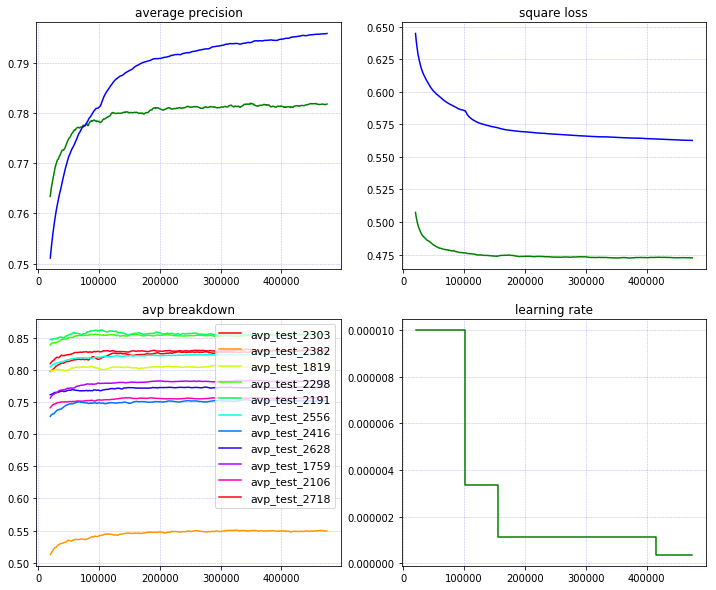

In [35]:
burnin=20
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2,2)
fig.set_figwidth(12)
fig.set_figheight(10)
ax1.set_title('average precision')
ax1.grid(color='b', linestyle='--', linewidth=0.5, alpha=0.3)
ax1.plot(model.stats['iter'][2][burnin:],model.stats['avp_test'][2][burnin:],color='g')
ax1.plot(model.stats['iter'][2][burnin:],model.stats['avp_train'][2][burnin:],color='b')
ax2.set_title('square loss')
ax2.grid(color='b', linestyle='--', linewidth=0.5, alpha=0.3)
ax2.plot(model.stats['iter'][2][burnin:],model.stats['mse_test'][2][burnin:],color='g')
ax2.plot(model.stats['iter'][2][burnin:],model.stats['mse_train'][2][burnin:],color='b')
ax3.set_title('avp breakdown')
ax3.grid(color='b', linestyle='--', linewidth=0.5, alpha=0.3)
cmap = plt.cm.get_cmap('hsv',len(model.test_ids))
plots = []
keys = []
for i,rec_id in enumerate(model.test_ids):
    plot, = ax3.plot(model.stats['iter'][2][burnin:], model.stats['avp_test_' + str(rec_id)][2][burnin:], color=cmap(i))
    plots.append(plot)
    keys.append('avp_test_' + str(rec_id))
leg = ax3.legend(plots,keys,loc='upper right',ncol=1,prop={'size':11})
ax4.set_title('learning rate')
ax4.grid(color='b', linestyle='--', linewidth=0.5, alpha=0.3)
ax4.plot(model.stats['iter'][2][burnin:],model.stats['lr'][2][burnin:],color='g')

print max(model.stats['avp_test'][2])
print min(model.stats['mse_test'][2])

# Mirex stats

In [6]:
mse_test, Yhat, Y, mse_breakdown, avp_breakdown = model.sample_records(config.test_ids, 7500, fixed_stride=512)
avp_test = average_precision_score(Y.flatten(),Yhat.flatten())
print avp_test

0.771022187915


In [7]:
Accavg = Etotavg = 0
for i in range(3):
    _,_,_,Acc,Etot = diagnostics.mirex_statistics(model,i,threshold=.4)
    Accavg += Acc
    Etotavg += Etot

print Accavg/3.,Etotavg/3.

AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
82.98	78.06	79.66	0.65	0.34	0.08	0.12	0.14
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
54.96	58.66	52.45	0.38	0.70	0.15	0.33	0.22
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
80.51	77.10	73.08	0.60	0.40	0.08	0.19	0.13
0.544760684697 0.481611460566


# Extended test set stats

In [8]:
mse_test, Yhat, Y, mse_breakdown, avp_breakdown = model.sample_records(config.test_ids_ext, 7500, fixed_stride=512)
avp_test = average_precision_score(Y.flatten(),Yhat.flatten())
print avp_test

0.794546498751


In [9]:
Accavg = Etotavg = 0
for i in range(10):
    _,_,_,Acc,Etot = diagnostics.mirex_statistics(model,i,threshold=.4)
    Accavg += Acc
    Etotavg += Etot

print Accavg/10.,Etotavg/10.

AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
82.98	78.06	79.66	0.65	0.34	0.08	0.12	0.14
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
54.96	58.66	52.45	0.38	0.70	0.15	0.33	0.22
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
80.51	77.10	73.08	0.60	0.40	0.08	0.19	0.13
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
85.60	76.15	82.39	0.65	0.32	0.12	0.06	0.14
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
85.55	72.98	86.95	0.66	0.35	0.10	0.03	0.22
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
82.51	76.15	80.49	0.64	0.36	0.09	0.10	0.16
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
75.23	63.43	82.10	0.56	0.59	0.06	0.12	0.41
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
77.35	69.74	79.19	0.59	0.45	0.10	0.11	0.24
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
78.36	71.40	80.95	0.61	0.41	0.10	0.09	0.22
AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
75.76	73.71	72.22	0.57	0.41	0.13	0.15	0.13
0.592191713013 0.432118243679
